In [1]:
import cudaq
import numpy as np
from math import floor
import tutorial_notebook.auxiliary_files.labs_utils as utils

In [2]:
@cudaq.kernel
def rzz(q0: cudaq.qubit, q1: cudaq.qubit, theta: float):
    cx(q0, q1)
    rz(2 * theta, q1)
    cx(q0, q1)

@cudaq.kernel
def two_qubit_block(q0: cudaq.qubit, q1: cudaq.qubit, theta: float):
    rx(math.pi / 2, q1)
    rzz(q0, q1, theta)
    rx(-math.pi / 2, q1)

    rx(math.pi / 2, q0)
    rzz(q0, q1, theta)
    rx(-math.pi / 2, q0)

@cudaq.kernel
def four_qubit_block(
    q0: cudaq.qubit,
    q1: cudaq.qubit,
    q2: cudaq.qubit,
    q3: cudaq.qubit,
    theta: float
):
    rx(-math.pi/2, q0)
    ry(math.pi/2, q1)
    ry(-math.pi/2, q2)
    rzz(q0, q1, -theta)
    rzz(q2, q3, -theta)
    rx(math.pi/2, q0)
    ry(-math.pi/2, q1)
    rx(-math.pi/2, q1)
    ry(math.pi/2, q2)
    rx(-math.pi/2, q2)
    rx(-math.pi/2, q3)
    rzz(q1, q2, theta)

    rx(math.pi/2, q1)
    rx(math.pi, q2)
    ry(-math.pi/2, q1)
    rzz(q0, q1, theta)
    rx(math.pi/2, q0)
    ry(-math.pi/2, q1)
    rzz(q1, q2, -theta)
    rx(math.pi/2, q1)
    rx(-math.pi, q2)
    rzz(q1, q2, -theta)

    rx(-math.pi, q1)
    ry(math.pi/2, q1)
    rzz(q2, q3, -theta)
    ry(-math.pi/2, q2)
    rx(-math.pi/2, q3)
    rx(-math.pi/2, q2)

    rzz(q1, q2, theta)
    rx(math.pi/2, q1)
    rx(math.pi/2, q2)
    ry(-math.pi/2, q1)
    ry(math.pi/2, q2)
    rzz(q0, q1, theta)
    rzz(q2, q3, theta)
    ry(math.pi/2, q1)
    ry(-math.pi/2, q2)
    rx(math.pi/2, q3)

In [3]:
def get_interactions(N):
    G2 = []
    G4 = []

    # Two-body terms
    for i in range(N - 2):
        max_k = (N - i) // 2
        for k in range(1, max_k + 1):
            G2.append([i, i + k])

    # Four-body terms
    for i in range(N - 3):
        max_t = (N - i - 1) // 2
        for t in range(1, max_t + 1):
            for k in range(t + 1, N - i - t):
                G4.append([i, i + t, i + k, i + k + t])

    return G2, G4

In [4]:
@cudaq.kernel
def trotterized_circuit(
    N: int,
    G2: list[list[int]],
    G4: list[list[int]],
    steps: int,
    dt: float,
    thetas: list[float]
):
    reg = cudaq.qvector(N)

    for q in reg:
        h(q)

    for step in range(steps):
        theta = thetas[step]

        for term in G2:
            i, j = term
            two_qubit_block(reg[i], reg[j], dt * theta)

        for term in G4:
            i, j, k, l = term
            four_qubit_block(reg[i],reg[j],reg[k],reg[l],dt * theta)
T=1
n_steps = 1
dt = T / n_steps
N = 20
G2, G4 = get_interactions(N)

thetas =[]

for step in range(1, n_steps + 1):
    t = step * dt
    theta_val = utils.compute_theta(t, dt, T, N, G2, G4)
    thetas.append(theta_val)

In [5]:
#identity tests
result = cudaq.sample(trotterized_circuit,N,G2,G4,n_steps,dt,thetas,shots_count=100)
result0 = cudaq.sample(trotterized_circuit,N,G2,G4,n_steps,dt,thetas,shots_count=100)

In [6]:
print(result)

{ 00100000001111110001:1 00100000101101111001:1 00100000111100110000:1 00100001011100011000:1 00100001011101000000:1 00100001011111000011:1 00100001101100101011:1 00100001101101000011:1 00100001101110011010:1 00100001111101111011:1 00100001111111111000:1 00100010011100000011:1 00100010101101101000:1 00100010101110010001:1 00100010101110111010:1 00100011011101111010:1 00100011101111110011:1 00101000001110001001:1 00101000011100101001:1 00101000011111010011:1 00101001011100011011:1 00101001011111001001:1 00101001111110011011:1 00101010011100111011:1 00101010101110000011:1 00101011101100011001:1 00101011101101101011:1 00101011101111101000:1 01100000011110111001:1 01100000101111000000:1 01100001001100110001:1 01100001001111011010:1 01100001101110101010:1 01100001101110110000:1 01100010001100001001:1 01100010101111111000:1 01100010111110010001:1 01100010111110111000:1 01100010111111101001:1 01100011011101010011:1 01100011011110011000:1 01100011101100110011:1 01100011111100111001:1 011010000

In [7]:
print(result0)

{ 00100000101101000000:1 00100000101101010011:1 00100001011110101000:1 00100001101100001001:1 00100001101101100001:1 00100001111110000011:1 00100010011110001001:1 00100010011110110000:1 00100010011111100001:1 00100010101110111011:1 00100010111100011000:1 00100010111100111010:1 00100011101101001010:1 00101000011101000010:1 00101000011110011001:1 00101000111110000000:1 00101001001100111000:1 00101001001101111011:1 00101001111100010011:1 00101010001111001001:1 00101010101101101010:1 00101010111110001001:1 00101011001111001001:1 00101011011110110010:1 01100000011101000010:1 01100000011110010001:1 01100000101100011010:1 01100000111101100011:1 01100000111110000011:1 01100000111111100011:1 01100001011101110010:1 01100001101111011001:1 01100010001110000011:1 01100010011100110010:1 01100011001101101001:1 01100011001110001011:1 01100011101110011010:1 01100011111110110010:1 01101000001101111010:1 01101000101100000010:1 01101000111111011000:1 01101000111111111011:1 01101001001100010011:1 011010010

In [8]:
# Since in each bit sequence the number of 1's and 0's are almost 50-50, it satisfies that they are random and each qubit is measured in z-basis and initialized with |+>.

In [9]:
def build_hamiltonian(N, G2, G4, J=1.0, K=1.0):
    H = cudaq.SpinOperator()

    # 2-body ZZ terms
    for (i, j) in G2:
        H += J * cudaq.spin.z(i) * cudaq.spin.z(j)

    # 4-body XXXX terms
    for (i, j, k, l) in G4:
        H += K * (
            cudaq.spin.x(i) *
            cudaq.spin.x(j) *
            cudaq.spin.x(k) *
            cudaq.spin.x(l)
        )

    return H

In [10]:
import numpy as np

# System parameters
N = 20
T = 1.0
n_steps = 4
dt = T / n_steps

# Interaction graph
G2, G4 = get_interactions(N)

# Hamiltonian
H = build_hamiltonian(N, G2, G4)

In [11]:
def energy(theta_vals):
    result = cudaq.observe(trotterized_circuit,H,N,G2,G4,n_steps,dt,theta_vals)
    return result.expectation()

In [12]:
from scipy.optimize import minimize
init_thetas = np.random.uniform(low=0.0,high=0.1,size=n_steps)
result = minimize(energy,init_thetas,method="COBYLA",options={"maxiter": 200,"disp": True})

optimal_thetas = result.x
ground_energy = result.fun


   Normal return from subroutine COBYLA

   NFVALS =   62   F =-1.021964E-01    MAXCV = 0.000000E+00
   X = 1.049904E+00   8.475354E-02   7.355626E-02  -1.939305E-02


In [13]:
print("VQE finished")
print("Optimal thetas:", optimal_thetas)
print("Estimated ground energy:", ground_energy)

VQE finished
Optimal thetas: [ 1.04990385  0.08475354  0.07355626 -0.01939305]
Estimated ground energy: -0.10219635561153667


In [14]:
N = 6
T = 1.0
steps = 1
dt = T / steps
G2, G4 = get_interactions(N)
H = build_hamiltonian(N, G2, G4)

In [15]:
theta_fixed = []

for step in range(1, steps + 1):
    t = step * dt
    theta_fixed.append(
        utils.compute_theta(t, dt, T, N, G2, G4)
    )

E_trotter = cudaq.observe(trotterized_circuit,H,N,G2,G4,steps,dt,theta_fixed).expectation()

In [16]:
import numpy as np
from scipy.optimize import minimize

def energy(theta):
    return cudaq.observe(trotterized_circuit,H,N,G2,G4,steps,dt,theta).expectation()

init_theta = np.random.uniform(0, 0.1, size=steps)

res = minimize(energy,init_theta,method="COBYLA",options={"maxiter": 50})

E_vqe = res.fun

In [17]:
print("Fixed trotter energy:", E_trotter)
print("VQE energy:         ", E_vqe)
print("Improvement ΔE:     ", E_trotter - E_vqe)

Fixed trotter energy: -6.352954513447652e-09
VQE energy:          -0.7437983630516101
Improvement ΔE:      0.7437983566986556


In [18]:
#Since ΔE > 0, hence VQE approach is better than the one proposed in paper!!

In [19]:
def vqe_energy(steps):
    dt = T / steps

    def energy(theta):
        return cudaq.observe(trotterized_circuit,H,N,G2,G4,steps,dt,theta).expectation()

    init_theta = np.random.uniform(0, 0.1, size=steps)
    res = minimize(energy,init_theta,method="COBYLA",options={"maxiter": 50})

    return res.fun

def fixed_trotter_energy(steps):
    dt = T / steps
    thetas = []
    for step in range(1, steps + 1):
        t = step * dt
        thetas.append(utils.compute_theta(t, dt, T, N, G2, G4))

    return cudaq.observe(trotterized_circuit,H,N,G2,G4,steps,dt,thetas).expectation()

N = 6
T = 1.0
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
G2, G4 = get_interactions(N)
H = build_hamiltonian(N, G2, G4)

In [20]:
print("Depth | Trotter Energy | VQE Energy")

for steps in depths:
    E_trot = fixed_trotter_energy(steps)
    E_vqe = vqe_energy(steps)

    print(f"{steps:5d} | {E_trot:14.6f} | {E_vqe:10.6f}")

Depth | Trotter Energy | VQE Energy
    1 |      -0.000000 |  -0.799224
    2 |       1.101578 |  -1.128952
    3 |       1.809149 |  -1.231472
    4 |      -0.103712 |  -1.574434
    5 |       1.000535 |  -1.276810
    6 |      -3.044699 |  -3.728134
    7 |      -0.015126 |  -1.811725
    8 |       1.024550 |  -1.886012
    9 |       1.954808 |  -1.932162
   10 |       0.001307 |  -1.883392


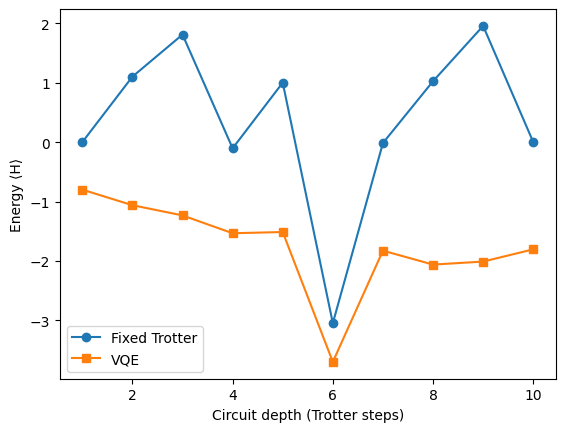

In [21]:
import matplotlib.pyplot as plt

trotter_vals = []
vqe_vals = []

for steps in depths:
    trotter_vals.append(fixed_trotter_energy(steps))
    vqe_vals.append(vqe_energy(steps))

plt.plot(depths, trotter_vals, "o-", label="Fixed Trotter")
plt.plot(depths, vqe_vals, "s-", label="VQE")
plt.xlabel("Circuit depth (Trotter steps)")
plt.ylabel("Energy ⟨H⟩")
plt.legend()
plt.show()

In [22]:
#It can also be seen here that VQE is generating population with lower energy than the trotter circuit given in paper!!

In [23]:
import cupy as cp

def bitstring_to_labs(bitstring):
    return cp.array([1 if b == '0' else -1 for b in bitstring], dtype=cp.int8)

def vqe_seeds_from_samples(result, N, top_k=20):
    sorted_states = sorted(result.items(), key=lambda x: x, reverse=True)
    seeds = []
    for bitstring, _ in sorted_states[:top_k]:
        s = bitstring_to_labs(bitstring)
        if len(s) == N:
            seeds.append(s)
    return seeds

def random_seq(N):
    return cp.random.choice([-1, 1], size=N).astype(cp.int8)
def labs_energy(s):
    N = len(s)
    E = 0
    for k in range(1, N):
        Ck = cp.sum(s[:-k] * s[k:])
        E += Ck * Ck
    return E
def tabu_search(start, iters=200, tenure=7):
    N = len(start)
    cur = start.copy()
    curE = labs_energy(cur)
    best = cur.copy()
    bestE = curE

    tabu_until = cp.zeros(N, dtype=int)  # when each index stops being tabu

    for t in range(1, iters + 1):
        best_move = None
        best_move_E = None

        for i in range(N):
            # aspiration: allow tabu move if it improves global best
            is_tabu = tabu_until[i] > t
            cur[i] *= -1
            E = labs_energy(cur)
            if (not is_tabu) or (E < bestE):
                if (best_move is None) or (E < best_move_E):
                    best_move = i
                    best_move_E = E
            cur[i] *= -1

        if best_move is None:
            break

        # apply move
        i = best_move
        cur[i] *= -1
        curE = best_move_E
        tabu_until[i] = t + tenure

        if curE < bestE:
            bestE = curE
            best = cur.copy()

    return best, bestE
def crossover(parent1, parent2):
    N = len(parent1)
    point = cp.random.randint(1, N)
    child = cp.empty_like(parent1)
    child[:point] = parent1[:point]
    child[point:] = parent2[point:]
    return child
def mutate(s, p_mut):
    flip_mask = cp.random.rand(len(s)) < p_mut
    s2 = s.copy()
    s2[flip_mask] *= -1
    return s2
def memetic_tabu_search(N, K=100, p_comb=0.9, p_mut=None, max_evals=10_000, ts_iters=200, tenure=7, vqe=False):
    if p_mut is None:
        p_mut = 1.0 / N

    # 1) random initial population
    pop = []
    if vqe:
        vqe_init = vqe_seeds_from_samples(result, N, top_k=min(20, K))
        pop.extend(vqe_init)
        while len(pop) < K:
            pop.append(random_seq(N))
    else:
        pop = [random_seq(N) for _ in range(K)]    
    
    energies = cp.array([labs_energy(s) for s in pop])
    evals = K

    best_idx = int(cp.argmin(energies))
    best = pop[best_idx].copy()
    bestE = energies[best_idx]

    while evals < max_evals:
        # 2) pick parents / single parent
        if cp.random.rand() < p_comb:
            i, j = cp.random.choice(K, size=2, replace=False)
            i = int(i)
            j = int(j)
            child = crossover(pop[i], pop[j])
        else:
            i = int(cp.random.randint(K))
            child = pop[i].copy()

        # 3) mutation
        child = mutate(child, p_mut)

        # 4) local improvement by tabu search
        improved, E_improved = tabu_search(child, iters=ts_iters, tenure=tenure)
        evals += ts_iters  # crude count; you can count exact evaluations if you log them

        # 5) population update
        if E_improved < bestE:
            bestE = E_improved
            best = improved.copy()

        # replace random individual if child is better
        worst_idx = cp.argmax(energies)
        if E_improved < energies[worst_idx]:
            replace_idx = int(cp.random.randint(K))
            pop[replace_idx] = improved
            energies[replace_idx] = E_improved

    return best, bestE

best, bestE = memetic_tabu_search(N=27, vqe=True)

In [24]:
best

array([-1,  1, -1, -1,  1,  1, -1,  1,  1, -1,  1, -1,  1, -1, -1, -1, -1,
       -1, -1, -1,  1,  1,  1, -1, -1, -1,  1], dtype=int8)

In [25]:
bestE

array(53)

In [26]:
best, bestE = memetic_tabu_search(N=27)

In [27]:
best

array([ 1,  1, -1,  1,  1, -1,  1,  1, -1,  1, -1,  1, -1,  1,  1,  1,  1,
        1,  1, -1, -1, -1,  1,  1, -1, -1, -1], dtype=int8)

In [28]:
bestE

array(53)